In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset
import torchvision.transforms as T
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
dtype = torch.float32
device = torch.device('cuda:0')

print("Current CUDA Device:", torch.cuda.current_device())

print("Device object:", torch.cuda.device(0))

print("Device count:", torch.cuda.device_count())

print("Device name:", torch.cuda.get_device_name(0))

print("CUDA Available:", torch.cuda.is_available())

Current CUDA Device: 0
Device object: <torch.cuda.device object at 0x000001E1B3D780D0>
Device count: 1
Device name: GeForce GTX 1070
CUDA Available: True


In [4]:
transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.4), (0.2))
])

# MNIST has 70,000 images
# We use 60,000 images. At test time, we will use the other 10,000 images.
NUM_TRAIN = 57000

mnist_train = dset.MNIST('./datasets', train=True, download=True,
                             transform=transform)
loader_train = DataLoader(mnist_train, batch_size=64, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

mnist_val = dset.MNIST('./datasets', train=True, download=True,
                           transform=transform)
loader_val = DataLoader(mnist_val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 60000)))

mnist_test = dset.MNIST('./datasets', train=False, download=True, 
                            transform=transform)
loader_test = DataLoader(mnist_test, batch_size=64)

In [5]:
model_conv = nn.Sequential(
    nn.Conv2d(1, 32, kernel_size=3, padding=1),
    nn.LeakyReLU(),
    nn.Conv2d(32,64,kernel_size=3, padding=1),
    nn.LeakyReLU(),
    nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)), # (N, 64, 14, 14)
    
    nn.BatchNorm2d(64),
    nn.LeakyReLU(),
    nn.Conv2d(64, 64, kernel_size=3, padding=1),
    nn.LeakyReLU(),
    nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)), # (N, 64, 7, 7)
    
    nn.Flatten(),
    nn.Linear(64*7*7, 64*4*4),
    nn.ReLU(),
    nn.Linear(64*4*4, 128),
    nn.ReLU(),
    nn.Linear(128,10),
    nn.Dropout(0.3)    
).to(device)

conv_optim = optim.Adam(model_conv.parameters(), weight_decay = 1e-2)

In [6]:
model_fc = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, 10)
).to(device=device, dtype=dtype)

fc_optim = optim.Adam(model_fc.parameters(), weight_decay = 1e-3)

In [7]:
def check_accuracy(loader, model, out=True):
    if loader.dataset.train and out:
        print('Checking accuracy on validation set')
    elif out:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        if out:
            print(f'Got {num_correct} / {num_samples} correct (%.2f)' % (100 * acc))
        return acc


In [8]:
def train_model(model, optimizer, loadert, loaderv, epochs=1, print_every=100):
    loss_hist = []
    train_acc_hist = []
    val_acc_hist = []
    running_loss,acct, accv = 0, 0, 0 
    for e in range(epochs):
        print(f"----------  Epoch {e}  ----------\n")
        for t, (x,y) in enumerate(loadert):
            x = x.to(device=device, dtype=dtype)
            y = y.to(device=device, dtype=torch.long)
            
            scores = model(x)
            loss = F.cross_entropy(scores, y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            if t % 10 == 0:
                loss_hist.append(running_loss / 10)
                running_loss = 0
                
            if t % print_every == 0:
                print(f"Iteration {t}: Loss = {loss.item()}")
                check_accuracy(loaderv, model)
                print()
        
        acct = check_accuracy(loadert, model, out=False)
        accv = check_accuracy(loaderv, model, out=True)
        train_acc_hist.append(acct)
        val_acc_hist.append(accv)
    
    
    return loss_hist, train_acc_hist, val_acc_hist
            

In [9]:
loss_hist_fc, train_hist_fc, val_hist_fc = train_model(model_fc, fc_optim, loader_train, loader_val, epochs=10, print_every=500)

----------  Epoch 0  ----------

Iteration 0: Loss = 2.330815315246582
Checking accuracy on validation set
Got 981 / 3000 correct (32.70)

Iteration 500: Loss = 0.26650315523147583
Checking accuracy on validation set
Got 2881 / 3000 correct (96.03)

Checking accuracy on validation set
Got 2857 / 3000 correct (95.23)
----------  Epoch 1  ----------

Iteration 0: Loss = 0.1784309595823288
Checking accuracy on validation set
Got 2870 / 3000 correct (95.67)

Iteration 500: Loss = 0.14977076649665833
Checking accuracy on validation set
Got 2899 / 3000 correct (96.63)

Checking accuracy on validation set
Got 2916 / 3000 correct (97.20)
----------  Epoch 2  ----------

Iteration 0: Loss = 0.044436462223529816
Checking accuracy on validation set
Got 2910 / 3000 correct (97.00)

Iteration 500: Loss = 0.19211100041866302
Checking accuracy on validation set
Got 2928 / 3000 correct (97.60)

Checking accuracy on validation set
Got 2926 / 3000 correct (97.53)
----------  Epoch 3  ----------

Iterati

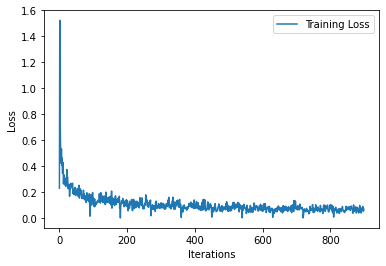

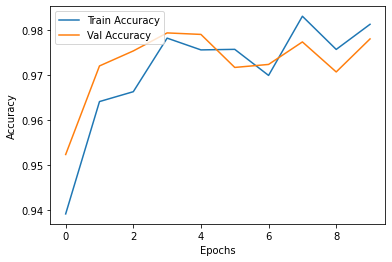

In [10]:
plt.figure(1)
# plt.subplot(211)
plt.plot(loss_hist_fc, label="Training Loss")
plt.legend(loc="upper right")
plt.ylabel("Loss")
plt.xlabel("Iterations")
plt.show()

plt.figure(2)
# plt.subplot(212)
plt.plot(train_hist_fc, label="Train Accuracy")
plt.plot(val_hist_fc, label="Val Accuracy")
plt.legend(loc = "upper left")
#plt.axis(ymin=0.0,ymax=1.0)
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.show()

In [11]:
check_accuracy(loader_test, model_fc)

Checking accuracy on test set
Got 9732 / 10000 correct (97.32)


0.9732

In [12]:
loss_hist_conv, train_hist_conv, val_hist_conv = train_model(model_conv, conv_optim, loader_train, loader_val, epochs=10, print_every=500)

----------  Epoch 0  ----------

Iteration 0: Loss = 2.3079636096954346
Checking accuracy on validation set
Got 314 / 3000 correct (10.47)

Iteration 500: Loss = 0.04033396765589714
Checking accuracy on validation set
Got 2922 / 3000 correct (97.40)

Checking accuracy on validation set
Got 2936 / 3000 correct (97.87)
----------  Epoch 1  ----------

Iteration 0: Loss = 0.1829782873392105
Checking accuracy on validation set
Got 2937 / 3000 correct (97.90)

Iteration 500: Loss = 0.024551454931497574
Checking accuracy on validation set
Got 2949 / 3000 correct (98.30)

Checking accuracy on validation set
Got 2953 / 3000 correct (98.43)
----------  Epoch 2  ----------

Iteration 0: Loss = 0.04468194767832756
Checking accuracy on validation set
Got 2954 / 3000 correct (98.47)

Iteration 500: Loss = 0.10751316696405411
Checking accuracy on validation set
Got 2941 / 3000 correct (98.03)

Checking accuracy on validation set
Got 2959 / 3000 correct (98.63)
----------  Epoch 3  ----------

Iterat

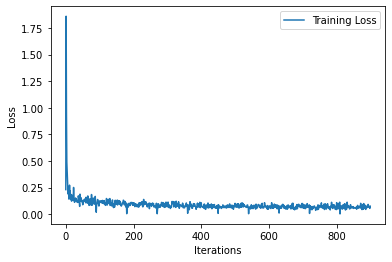

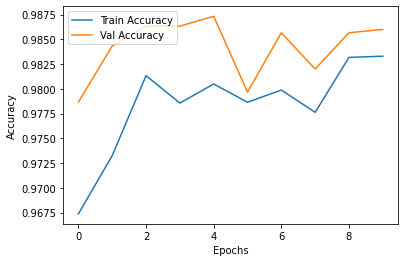

In [13]:
plt.figure(1)
# plt.subplot(211)
plt.plot(loss_hist_conv, label="Training Loss")
plt.legend(loc="upper right")
plt.ylabel("Loss")
plt.xlabel("Iterations")
plt.show()

plt.figure(2)
# plt.subplot(212)
plt.plot(train_hist_conv, label="Train Accuracy")
plt.plot(val_hist_conv, label="Val Accuracy")
plt.legend(loc = "upper left")
#plt.axis(ymin=0.0,ymax=1.0)
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.show()

In [14]:
check_accuracy(loader_test, model_conv)

Checking accuracy on test set
Got 9843 / 10000 correct (98.43)


0.9843

In [15]:
transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.4), (0.2))
])

# Fashion MNIST has 70,000 images
# We use 60,000 images. At test time, we will use the remaining 10,000 images.
NUM_TRAIN = 57000

fash_train = dset.FashionMNIST('./datasets', train=True, download=True,
                             transform=transform)
loader_train = DataLoader(fash_train, batch_size=64, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

fash_val = dset.FashionMNIST('./datasets', train=True, download=True,
                           transform=transform)
loader_val = DataLoader(fash_val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 60000)))

fash_test = dset.FashionMNIST('./datasets', train=False, download=True, 
                            transform=transform)
loader_test = DataLoader(fash_test, batch_size=64)

for layer in model_fc.children():
    if hasattr(layer, 'reset_parameters'):
        layer.reset_parameters()
for layer in model_conv.children():
    if hasattr(layer, 'reset_parameters'):
        layer.reset_parameters()

In [16]:
fc_optim = optim.SGD(model_fc.parameters(), lr=1e-3, momentum=0.9, nesterov=True)
loss_hist_fc, train_hist_fc, val_hist_fc = train_model(model_fc, fc_optim, loader_train, loader_val, epochs=10, print_every=500)

----------  Epoch 0  ----------

Iteration 0: Loss = 2.3499886989593506
Checking accuracy on validation set
Got 282 / 3000 correct (9.40)

Iteration 500: Loss = 0.6413169503211975
Checking accuracy on validation set
Got 2406 / 3000 correct (80.20)

Checking accuracy on validation set
Got 2466 / 3000 correct (82.20)
----------  Epoch 1  ----------

Iteration 0: Loss = 0.518134355545044
Checking accuracy on validation set
Got 2459 / 3000 correct (81.97)

Iteration 500: Loss = 0.42300945520401
Checking accuracy on validation set
Got 2517 / 3000 correct (83.90)

Checking accuracy on validation set
Got 2562 / 3000 correct (85.40)
----------  Epoch 2  ----------

Iteration 0: Loss = 0.26557379961013794
Checking accuracy on validation set
Got 2560 / 3000 correct (85.33)

Iteration 500: Loss = 0.4397466778755188
Checking accuracy on validation set
Got 2569 / 3000 correct (85.63)

Checking accuracy on validation set
Got 2555 / 3000 correct (85.17)
----------  Epoch 3  ----------

Iteration 0: L

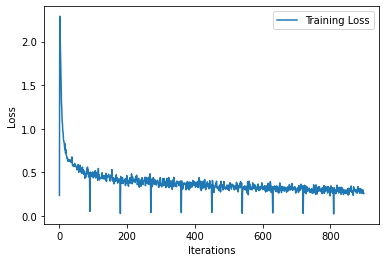

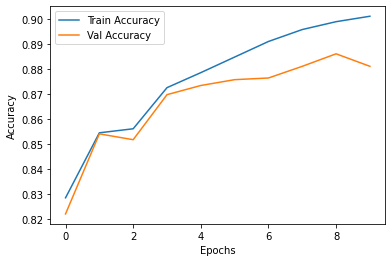

In [17]:
plt.figure(1)
# plt.subplot(211)
plt.plot(loss_hist_fc, label="Training Loss")
plt.legend(loc="upper right")
plt.ylabel("Loss")
plt.xlabel("Iterations")
plt.show()

plt.figure(2)
# plt.subplot(212)
plt.plot(train_hist_fc, label="Train Accuracy")
plt.plot(val_hist_fc, label="Val Accuracy")
plt.legend(loc = "upper left")
#plt.axis(ymin=0.0,ymax=1.0)
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.show()

In [18]:
check_accuracy(loader_test, model_fc)

Checking accuracy on test set
Got 8728 / 10000 correct (87.28)


0.8728

In [19]:
conv_optim = optim.SGD(model_conv.parameters(), lr=1e-3, momentum=0.9, nesterov=True)
loss_hist_conv, train_hist_conv, val_hist_conv = train_model(model_conv, conv_optim, loader_train, loader_val, epochs=10, print_every=500)

----------  Epoch 0  ----------

Iteration 0: Loss = 2.309011697769165
Checking accuracy on validation set
Got 299 / 3000 correct (9.97)

Iteration 500: Loss = 0.4423583149909973
Checking accuracy on validation set
Got 2345 / 3000 correct (78.17)

Checking accuracy on validation set
Got 2406 / 3000 correct (80.20)
----------  Epoch 1  ----------

Iteration 0: Loss = 0.5264251232147217
Checking accuracy on validation set
Got 2408 / 3000 correct (80.27)

Iteration 500: Loss = 0.5999256372451782
Checking accuracy on validation set
Got 2512 / 3000 correct (83.73)

Checking accuracy on validation set
Got 2538 / 3000 correct (84.60)
----------  Epoch 2  ----------

Iteration 0: Loss = 0.46761876344680786
Checking accuracy on validation set
Got 2539 / 3000 correct (84.63)

Iteration 500: Loss = 0.3932352364063263
Checking accuracy on validation set
Got 2589 / 3000 correct (86.30)

Checking accuracy on validation set
Got 2599 / 3000 correct (86.63)
----------  Epoch 3  ----------

Iteration 0:

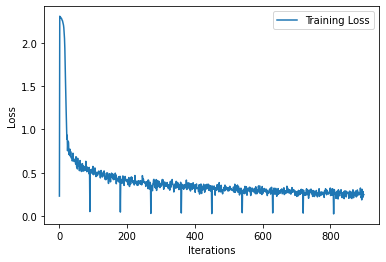

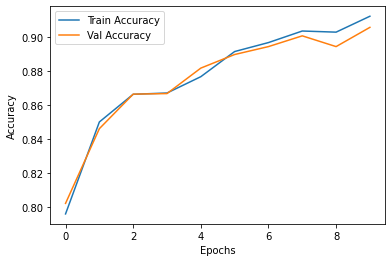

In [20]:
plt.figure(1)
# plt.subplot(211)
plt.plot(loss_hist_conv, label="Training Loss")
plt.legend(loc="upper right")
plt.ylabel("Loss")
plt.xlabel("Iterations")
plt.show()

plt.figure(2)
# plt.subplot(212)
plt.plot(train_hist_conv, label="Train Accuracy")
plt.plot(val_hist_conv, label="Val Accuracy")
plt.legend(loc = "upper left")
#plt.axis(ymin=0.0,ymax=1.0)
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.show()

In [21]:
check_accuracy(loader_test, model_conv)

Checking accuracy on test set
Got 8959 / 10000 correct (89.59)


0.8959